In [14]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib.font_manager import FontProperties
import seaborn as sns
sns.set_theme()
plt.rcParams["font.family"] = "Times New Roman"

import IMP
import IMP.atom
import IMP.core

sys.path.append(str(Path(Path.home(), "Documents/xray/src")))
from average_structure import get_coord_avg_dict


In [20]:
cif_names = ["7mhf", "7mhg", "7mhh", "7mhi", "7mhj", "7mhk"]
Ns = [1, 2, 4, 8]
ms = list()
hs_arr = np.ndarray(shape=(len(cif_names), 4), dtype=object)
for cif_id in range(len(cif_names)):
    cif_name = cif_names[cif_id]
    for N_id in range(4):
        N = Ns[N_id]

        pdb_file = Path(Path.home(), "Documents/xray/sample_bench/data/7mhf/166_N1/summary_15/{}_N{}.pdb".format(cif_name, N))

        m = IMP.Model()
        hs = IMP.atom.read_multimodel_pdb(str(pdb_file), m, IMP.atom.AllPDBSelector())

        ms.append(m)
        hs_arr[cif_id, N_id] = hs

n_res = len(IMP.atom.Selection(hs_arr[0,0][0], atom_type=IMP.atom.AT_CA).get_selected_particle_indexes())


In [80]:
# rmsf_mat = np.zeros(shape=(len(cif_names), n_res))
rmsf_df = pd.DataFrame()
# atom_types = [IMP.atom.AT_CA, IMP.atom.AT_N, IMP.atom.AT_C, IMP.atom.AT_O]
# skip_atoms = [IMP.atom.AT_N, IMP.atom.AT_C, IMP.atom.AT_O]
skip_atoms = list()
# atom_types = []

# for cif_id in range(len(cif_names)):
for cif_id in [2]:
    cif_name = cif_names[cif_id]
    for N_id in range(4):
        N = Ns[N_id]
        hs = hs_arr[cif_id, N_id]

        avg_coord_dict = get_coord_avg_dict(hs, np.array([1/len(hs)]*len(hs)))

        for res_id in range(1,n_res+1):
            rmsf = 0
            for h in hs:
                # pids = IMP.atom.Selection(h, residue_index=res_id, atom_types=atom_types).get_selected_particle_indexes()
                # pids_keys = IMP.atom.Selection(hs[0], residue_index=res_id, atom_types=atom_types).get_selected_particle_indexes()

                sel = IMP.atom.Selection(h, residue_index=res_id)
                sel_keys = IMP.atom.Selection(hs[0], residue_index=res_id)

                # sel = IMP.atom.Selection(h, residue_index=res_id) - IMP.atom.Selection(h, atom_type=IMP.atom.AT_CA, residue_index=res_id) - IMP.atom.Selection(h, atom_type=IMP.atom.AT_N, residue_index=res_id) - IMP.atom.Selection(h, atom_type=IMP.atom.AT_C, residue_index=res_id) - IMP.atom.Selection(h, atom_type=IMP.atom.AT_O, residue_index=res_id)

                # sel_keys = IMP.atom.Selection(hs[0], residue_index=res_id) - IMP.atom.Selection(hs[0], atom_type=IMP.atom.AT_CA, residue_index=res_id) - IMP.atom.Selection(hs[0], atom_type=IMP.atom.AT_N, residue_index=res_id) - IMP.atom.Selection(hs[0], atom_type=IMP.atom.AT_C, residue_index=res_id) - IMP.atom.Selection(hs[0], atom_type=IMP.atom.AT_O, residue_index=res_id)

                pids = sel.get_selected_particle_indexes()
                pids_keys = sel_keys.get_selected_particle_indexes()

                # print(pids, pids_keys)

                mat_id = res_id-1

                for i in range(len(pids)):
                    at = IMP.atom.Atom(m, pids[i])
                    if at.get_atom_type() in skip_atoms:
                        # print("skip")
                        continue

                    xyz = IMP.core.XYZ(m, pids[i])
                    norm = np.linalg.norm(avg_coord_dict[pids_keys[i]] - xyz.get_coordinates())

                    # if res_id == 194 and hs_id == 0:
                    #     print(norm)

                    rmsf += norm**2

            n_res_atoms = len(pids) - len(skip_atoms)
            if n_res_atoms == 0:
                rmsf = 0
            else:
                rmsf = rmsf / (len(hs) * n_res_atoms)
            rmsf = np.sqrt(rmsf)

            rmsf_df.loc[res_id, "{}_{}_r".format(cif_name, N)] = rmsf

rmsf_df.head()



,7mhh_1_r,7mhh_2_r,7mhh_4_r,7mhh_8_r
1,1.514022,1.579534,2.666962,2.336130
2,1.671899,1.659053,1.885926,1.693482
3,1.017267,1.209899,1.770799,2.236948
4,0.327492,1.004995,1.830581,2.321748
5,1.227580,0.876828,4.701327,3.793039


In [82]:
for cif_name in cif_names:
    m_ref = IMP.Model()
    h_ref = IMP.atom.read_pdb(str(Path(Path.home(), "Documents/xray/data/pdbs/7mhf/{}.pdb".format(cif_name))), m_ref, IMP.atom.NonAlternativePDBSelector())

    for res_id in range (1, n_res+1):
        res_pids = IMP.atom.Selection(h_ref, residue_index=res_id).get_selected_particle_indexes()

        res_b_factor = 0
        for res_pid in res_pids:

            if IMP.atom.Atom(m_ref, res_pid).get_atom_type() in skip_atoms:
                continue

            res_b_factor = res_b_factor + IMP.atom.Atom(m_ref, res_pid).get_temperature_factor()

        n_res_atoms = len(res_pids) - len(skip_atoms)

        # print(res_b_factor)
        rmsf_df.loc[res_id, "{}_b".format(cif_name)] = res_b_factor/n_res_atoms

rmsf_df.head()

begin read_pdb:
  WARNING  Could not determine CHARMM atom type for atom "HET: O  " in residue #803 "HOH"
  WARNING  Could not determine CHARMM atom type for atom "HE2" in residue #163 "HIS"
  WARNING  Could not determine CHARMM atom type for atom "HET: S  " in residue #401 "DMS"
  WARNING  Could not determine CHARMM atom type for atom "HET: O  " in residue #401 "DMS"
  WARNING  Could not determine CHARMM atom type for atom "HET: C1 " in residue #401 "DMS"
  WARNING  Could not determine CHARMM atom type for atom "HET: C2 " in residue #401 "DMS"
  WARNING  Could not determine CHARMM atom type for atom "HET: H11" in residue #401 "DMS"
  WARNING  Could not determine CHARMM atom type for atom "HET: H12" in residue #401 "DMS"
  WARNING  Could not determine CHARMM atom type for atom "HET: H13" in residue #401 "DMS"
  WARNING  Could not determine CHARMM atom type for atom "HET: H21" in residue #401 "DMS"
  WARNING  Could not determine CHARMM atom type for atom "HET: H22" in residue #401 "DMS"

,7mhh_1_r,7mhh_2_r,7mhh_4_r,7mhh_8_r,7mhf_b,7mhg_b,7mhh_b,7mhi_b,7mhj_b,7mhk_b
1,1.514022,1.579534,2.666962,2.336130,37.908462,34.975384,39.414615,44.126154,55.481540,48.046923
2,1.671899,1.659053,1.885926,1.693482,30.790000,32.040000,36.701428,38.765713,48.628571,42.597142
3,1.017267,1.209899,1.770799,2.236948,24.531000,26.533000,34.210500,34.738000,42.057000,39.417000
4,0.327492,1.004995,1.830581,2.321748,26.885417,25.202500,32.615417,33.687500,45.018750,40.291667
5,1.227580,0.876828,4.701327,3.793039,25.577273,27.486364,38.330909,40.213636,48.842272,44.087273


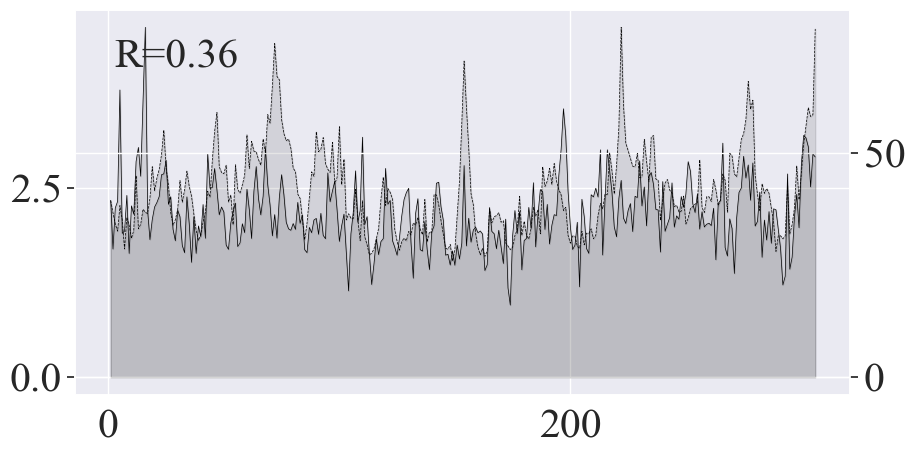

In [83]:
# fig, axs = plt.subplots(3,1, figsize=(8,10))
fig, ax = plt.subplots(1,1, figsize=(10,5))
axs = [ax]

i = 0
for y_1_field, y_2_field in [("7mhh_8_r", "7mhh_b")]:
    ax = axs[i]
    y_1 = rmsf_df[y_1_field]
    y_2 = rmsf_df[y_2_field]

    ax.plot(rmsf_df.index, y_1, c="black", linewidth=0.5)

    if i == 0:
        ax_2 = ax.twinx()
    else:
        ax_2 = ax

    ax_2.plot(rmsf_df.index, y_2, '--', color="black", linewidth=0.5)

    ax.fill_between(rmsf_df.index, np.array([0]*len(rmsf_df)), y_1, alpha=0.1, color="black")
    ax_2.fill_between(rmsf_df.index, np.array([0]*len(rmsf_df)), y_2, alpha=0.1, color="black")

    r = y_2.corr(y_1)
    ax.annotate("R={:.2f}".format(r), xy=(.05, .85), xycoords=ax.transAxes, fontsize=30)

    ax.locator_params(axis='x', nbins=2)
    ax.locator_params(axis='y', nbins=2)
    ax_2.locator_params(axis='y', nbins=2)
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)
    ax_2.tick_params(axis='y', labelsize=30)

    # if i == 0:
    #     ax.tick_params(bottom=False, labelbottom=False)

    i+=1

# plt.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.savefig(Path(Path.home(), "Desktop/fig.png"))


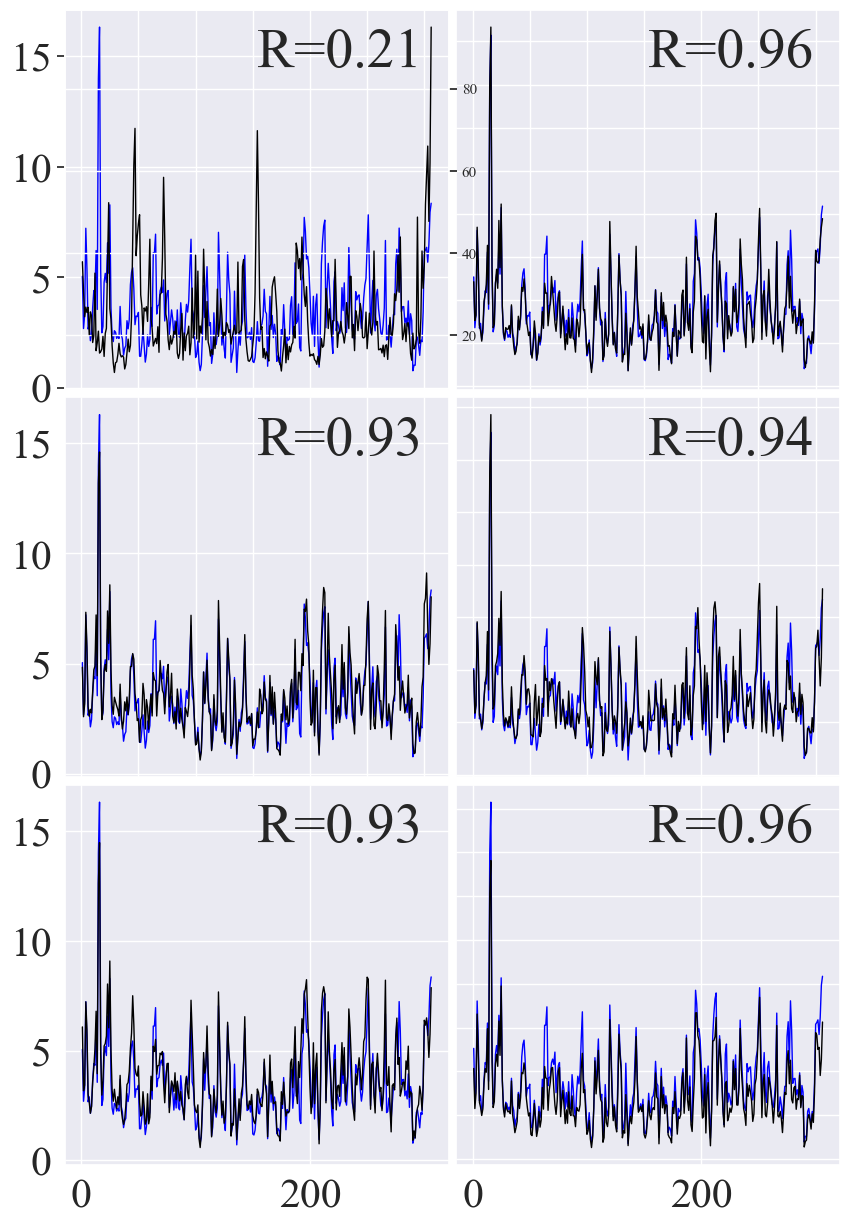

In [141]:
fig, axs = plt.subplots(3,2, figsize=(10, 15))

for i in range(6):
    ax = axs[i//2, i%2]
    xs = list(rmsf_df.index)
    y_1s = rmsf_df["7mhf_rmsf"]

    color_1, color_2 = "blue", "black"

    ax.plot(xs, y_1s, alpha=1, linewidth=1, c=color_1, linestyle="-")
    if i == 0:
        y_2s = rmsf_df["7mhf_b"]
        ax_2 = ax.twinx()
        ax_2.plot(xs, y_2s, alpha=1, linewidth=1, c=color_2, linestyle="-")
    else:
        y_2s = rmsf_df["{}_rmsf".format(cif_names[i])]
        ax.plot(xs, y_2s, alpha=1, linewidth=1, c=color_2, linestyle="-")

    # plt.plot([1, n_res+1], [np.mean(rmsf_mat[cif_1, :]), np.mean(rmsf_mat[cif_1, :])], color=color_1, linestyle="--")
    # plt.plot([1, n_res+1], [np.mean(rmsf_mat[cif_2, :]), np.mean(rmsf_mat[cif_2, :])], color=color_2, linestyle="--")

    ax.annotate("R={:.2f}".format(y_2s.corr(y_1s)), xy=(.5, .85), xycoords=ax.transAxes, fontsize=40)

    # if i == 0:
    #     ax_2.tick_params(axis='y', labelsize=30)

    if i % 2 == 0:
        ax.tick_params(axis='y', labelsize=30)
    else:
        ax.tick_params(left = False, labelleft = False)

    if i in [4, 5]:
        ax.tick_params(axis='x', labelsize=30)
    else:
        ax.tick_params(bottom = False, labelbottom = False)

    # if i in [5, 6]:
plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.savefig(Path(Path.home(), "Desktop/fig.png"))

begin read_pdb:
  WARNING  Could not determine CHARMM atom type for atom "HET: O  " in residue #567 "HOH"
  WARNING  Could not determine CHARMM atom type for atom "H1" in residue #1 "SER"
  WARNING  Could not determine CHARMM atom type for atom "HE2" in residue #41 "HIS"
  WARNING  Could not determine CHARMM atom type for atom "HET: S  " in residue #401 "DMS"
  WARNING  Could not determine CHARMM atom type for atom "HET: O  " in residue #401 "DMS"
  WARNING  Could not determine CHARMM atom type for atom "HET: C1 " in residue #401 "DMS"
  WARNING  Could not determine CHARMM atom type for atom "HET: C2 " in residue #401 "DMS"
  WARNING  Could not determine CHARMM atom type for atom "HET: H11" in residue #401 "DMS"
  WARNING  Could not determine CHARMM atom type for atom "HET: H12" in residue #401 "DMS"
  WARNING  Could not determine CHARMM atom type for atom "HET: H13" in residue #401 "DMS"
  WARNING  Could not determine CHARMM atom type for atom "HET: H21" in residue #401 "DMS"
  WARNIN

[[1.         0.35830731]
 [0.35830731 1.        ]]


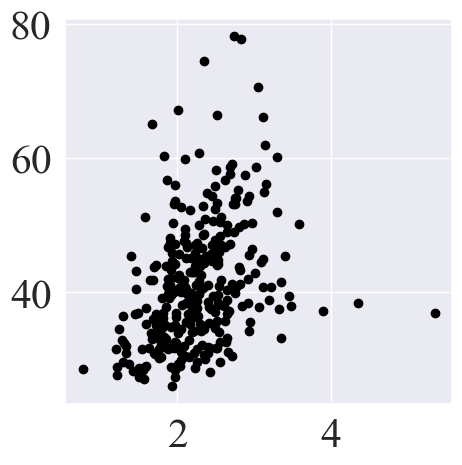

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.scatter(rmsf_df["7mhh_8_r"], rmsf_df["7mhh_b"], color="black")

ax.locator_params(axis='y', nbins=3)
ax.locator_params(axis='x', nbins=3)

ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)

print(np.corrcoef(rmsf_df["7mhh_8_r"], rmsf_df["7mhh_b"]))

# plt.tight_layout()
# plt.savefig(Path(Path.home(), "Desktop/rmsf.png"))

In [21]:
np.corrcoef(res_b_factors[0], rmsf_mat[0])

array([[1.        , 0.45305277],
       [0.45305277, 1.        ]])